<center>
<h1> Credit Risk Analytics
</center>

###### Definition of Target and Outcome Window:
One of the leading banks would like to predict bad customer while customer applying for loan. This model also called as PD Models (Probability of Default)


###### Data Pre-Processing - 
    - Missing Values Treatment - Numerical (Mean/Median imputation) and Categorical (Separate Missing Category or Merging)
    - Univariate Analysis - Outlier and Frequency Analysis
###### Data Exploratory Analysis
    - Bivariate Analysis - Numeric(TTest) and Categorical(Chisquare)
    - Bivariate Analysis - Visualization
    - Variable Transformation - P-Value based selection
    - Variable Transformation - Bucketing / Binning for numerical variables and Dummy for Categorical Variables
    - Variable Reduction - IV / Somers'D
    - Variable Reduction - Multicollinearity
###### Model Build and Model Diagnostics
    - Train and Test split
    - Significance of each Variable
    - Gini and ROC / Concordance analysis - Rank Ordering
    - Classification Table Analysis - Accuracy

###### Model Validation
    - OOS validation - p-value and sign testing for the model coefficients
    - Diagnostics check to remain similar to Training Model build
    - BootStrapping, if necessary
###### Model Interpretation for its properties
    - Inferencing for finding the most important contributors
    - Prediction of risk and proactive prevention by targeting segments of the population

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
import scipy.stats as stats
import pandas_profiling   #need to install using anaconda prompt (pip install pandas_profiling)

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

<Figure size 720x540 with 0 Axes>

In [30]:
# Load the data
bankloans = pd.read_csv( 'bankloans.csv' )

In [5]:
bankloans.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [6]:
bankloans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 9 columns):
age         850 non-null int64
ed          850 non-null int64
employ      850 non-null int64
address     850 non-null int64
income      850 non-null int64
debtinc     850 non-null float64
creddebt    850 non-null float64
othdebt     850 non-null float64
default     700 non-null float64
dtypes: float64(4), int64(5)
memory usage: 59.8 KB


In [7]:
# ensure that you have categorical variables as strings
bankloans.ed = bankloans.ed.astype(str)
bankloans.default = bankloans.default.astype(str)

pandas_profiling.ProfileReport(bankloans)


Number of variables,9
Number of observations,850
Total Missing (%),0.0%
Total size in memory,59.8 KiB
Average record size in memory,72.1 B
Numeric,7
Categorical,2
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [33]:
bankloans.ed = bankloans.ed.astype(float)
bankloans.default = bankloans.default.astype(float)

In [34]:
#Seperating Continuous and Categorical variables
numeric_var_names=[key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_names=[key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['object']]
print(numeric_var_names)
print(cat_var_names)

['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt', 'othdebt', 'default']
[]


In [35]:
bankloans_num=bankloans[numeric_var_names]
bankloans_num.head(5)

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3.0,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1.0,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1.0,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1.0,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2.0,2,0,28,17.3,1.787436,3.056564,1.0


In [11]:
bankloans_cat = bankloans[cat_var_names]
bankloans_cat.head(5)

""
0
1
2
3
4


In [36]:
# Creating Data audit Report
# Use a general function that returns multiple values
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

num_summary=bankloans_num.apply(lambda x: var_summary(x)).T

In [37]:
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,850.0,0.0,29775.000000,35.029412,34.000000,8.041432,64.664623,20.000000,21.000000,23.000000,25.000000,29.000000,34.000000,41.000000,47.000000,49.000000,53.000000,56.00000
ed,850.0,0.0,1454.000000,1.710588,1.000000,0.927784,0.860783,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,4.000000,4.000000,5.00000
employ,850.0,0.0,7281.000000,8.565882,7.000000,6.777884,45.939706,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,13.000000,18.000000,21.550000,29.000000,33.00000
address,850.0,0.0,7116.000000,8.371765,7.000000,6.895016,47.541251,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,12.000000,19.000000,22.550000,26.510000,34.00000
income,850.0,0.0,39674.000000,46.675294,35.000000,38.543054,1485.566998,13.000000,14.490000,17.000000,19.000000,24.000000,35.000000,55.750000,84.000000,115.550000,220.510000,446.00000
debtinc,850.0,0.0,8645.900000,10.171647,8.700000,6.719441,45.150891,0.100000,0.900000,1.900000,2.900000,5.100000,8.700000,13.800000,19.200000,23.510000,31.565000,41.30000
creddebt,850.0,0.0,1340.284021,1.576805,0.885091,2.125840,4.519196,0.011696,0.030349,0.108927,0.178306,0.382176,0.885091,1.898440,3.703304,5.348674,10.285997,20.56131
othdebt,850.0,0.0,2616.970979,3.078789,2.003243,3.398803,11.551864,0.045584,0.162394,0.359900,0.552050,1.045942,2.003243,3.903001,7.111941,9.481105,16.931503,35.19750
default,700.0,150.0,183.000000,0.261429,0.000000,0.439727,0.193360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.00000


## Get training and testing

### Where ever _default_ status is missing : New set of cust : test
### Rest is training



In [38]:
bankloans_existing = bankloans[bankloans.default.isnull()==0]
bankloans_new = bankloans[bankloans.default.isnull()==1]

In [39]:
bankloans_new.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
700,36,1.0,16,13,32,10.9,0.544128,2.943872,NaN
701,50,1.0,6,27,21,12.9,1.316574,1.392426,NaN
702,40,1.0,9,9,33,17.0,4.880700,0.729300,NaN
703,31,1.0,5,7,23,2.0,0.046000,0.414000,NaN
704,29,1.0,4,0,24,7.8,0.866736,1.005264,NaN


In [42]:
#Handling Outliers - Method2
def outlier_capping(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

bankloans_existing=bankloans_existing.apply(lambda x: outlier_capping(x))

In [43]:
#Handling missings - Method2
def Missing_imputation(x):
    x = x.fillna(x.median())
    return x

bankloans_existing=bankloans_existing.apply(lambda x: Missing_imputation(x))

In [44]:
bankloans_existing.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41.0,3.0,17.0,12.0,176.0,9.3,9.876748,5.008608,1.0
1,27.0,1.0,10.0,6.0,31.0,17.3,1.362202,4.000798,0.0
2,40.0,1.0,15.0,14.0,55.0,5.5,0.856075,2.168925,0.0
3,41.0,1.0,15.0,14.0,120.0,2.9,2.658720,0.821280,0.0
4,24.0,2.0,2.0,0.0,28.0,17.3,1.787436,3.056564,1.0


In [45]:
nums = bankloans_existing.columns.difference(other=["ed","default"])
bankloans_num = bankloans_existing[nums]
bankloans_num.corr()

,address,age,creddebt,debtinc,employ,income,othdebt
address,1.000000,0.596974,0.215407,0.014971,0.324867,0.345137,0.234901
age,0.596974,1.000000,0.308324,0.016918,0.537418,0.521540,0.348906
creddebt,0.215407,0.308324,1.000000,0.534690,0.405940,0.553006,0.639947
debtinc,0.014971,0.016918,0.534690,1.000000,-0.035339,-0.022538,0.603630
employ,0.324867,0.537418,0.405940,-0.035339,1.000000,0.665488,0.419323
income,0.345137,0.521540,0.553006,-0.022538,0.665488,1.000000,0.626773
othdebt,0.234901,0.348906,0.639947,0.603630,0.419323,0.626773,1.000000


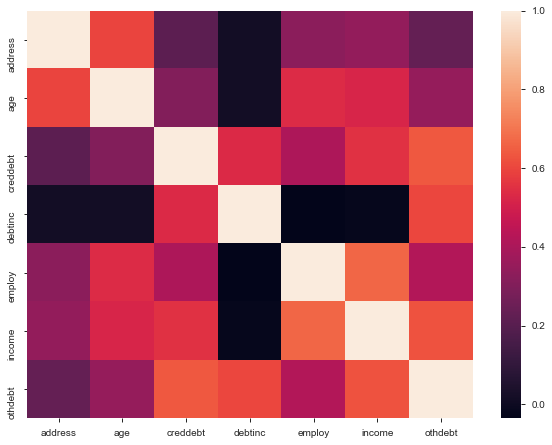

In [46]:
# visualize correlation matrix in Seaborn using a heatmap
sns.heatmap(bankloans_num.corr())

###### 2.4 Data Exploratory Analysis
    - Variable Transformation: (i) Bucketing

In [47]:
bankloans_existing.columns.difference(['default'])


Index(['address', 'age', 'creddebt', 'debtinc', 'ed', 'employ', 'income',
       'othdebt'],
      dtype='object')

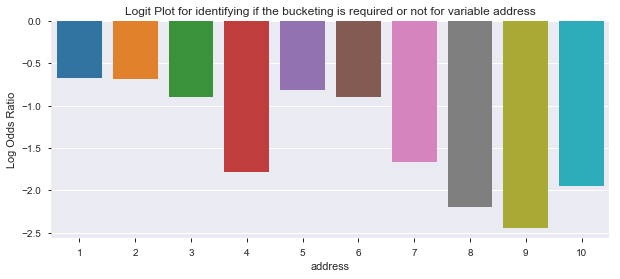

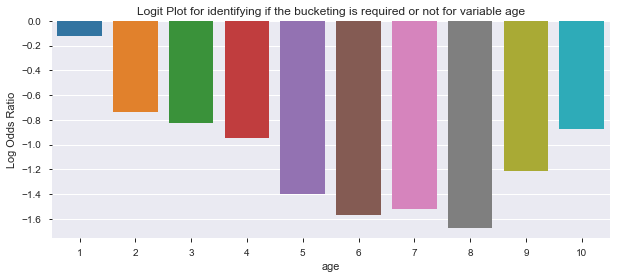

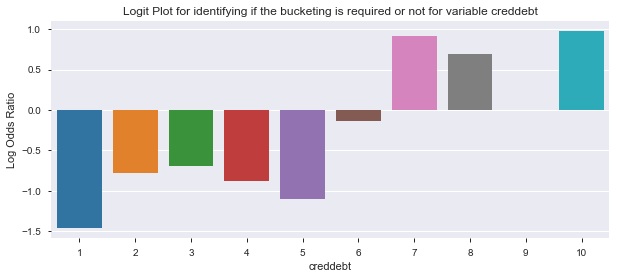

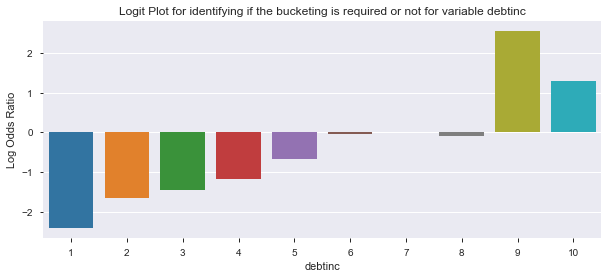

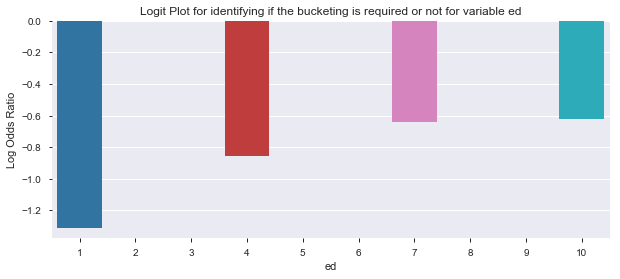

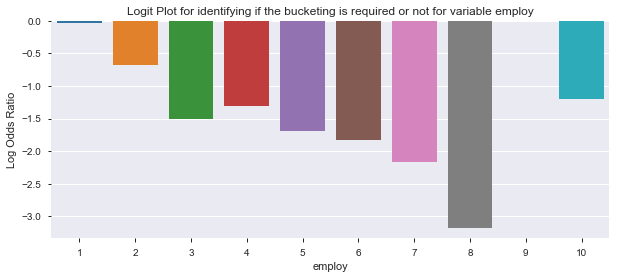

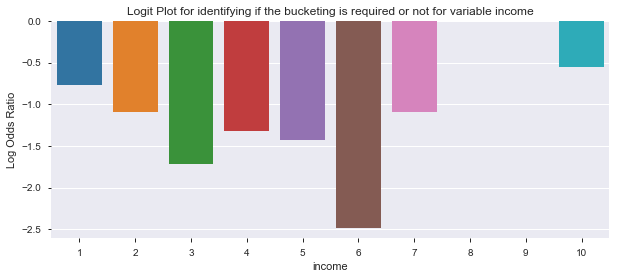

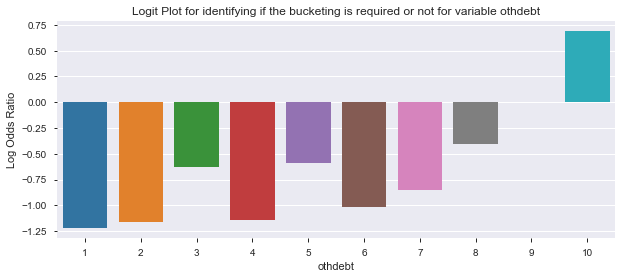

In [48]:
#Checking relation between dependent variable and Independent variable using plots
bp = PdfPages('Transformation Plots.pdf')
for num_variable in bankloans_existing.columns.difference(['default']):
    binned = pd.cut(bankloans_existing[num_variable], bins=10, labels=list(range(1,11)))
    #binned = binned.dropna()
    #----------------------------------------------------------------------
    # The formukla for log odds
    # log(p/1-p)
    #----------------------------------------------------------------------
    odds = bankloans_existing.groupby(binned)['default'].sum() / (bankloans_existing.groupby(binned)['default'].count()-bankloans_existing.groupby(binned)['default'].sum())
    log_odds = np.log(odds)
    #----------------------------------------------------------------------

    fig,axes = plt.subplots(figsize=(10,4))
    sns.barplot(x=log_odds.index,y=log_odds)
    plt.ylabel('Log Odds Ratio')
    plt.title(str('Logit Plot for identifying if the bucketing is required or not for variable ') + str(num_variable))
    bp.savefig(fig)

bp.close()


###### 2.5 Data Exploratory Analysis
    - Variable Reduction using Somer's D values

In [49]:
bankloans_existing.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [50]:
#Conducting univarite logistics regression 
logreg_model = sm.logit('default~debtinc', data= bankloans_existing).fit()

Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6


In [51]:
#Predicting values 
p = logreg_model.predict(bankloans_existing)
p # probability
# predict_proba

0      0.212978
1      0.439630
2      0.140317
3      0.103531
4      0.439630
5      0.233738
6      0.821554
7      0.112500
8      0.668631
9      0.519155
10     0.089622
11     0.135571
12     0.229006
13     0.407161
14     0.208552
15     0.197784
16     0.410377
17     0.177518
18     0.143558
19     0.089622
20     0.107295
21     0.141930
22     0.229006
23     0.224342
24     0.462688
25     0.449486
26     0.160704
27     0.420068
28     0.475942
29     0.341837
         ...   
670    0.153655
671    0.301242
672    0.084341
673    0.255864
674    0.113835
675    0.155393
676    0.273996
677    0.094061
678    0.212978
679    0.104772
680    0.697421
681    0.222035
682    0.266128
683    0.153655
684    0.240963
685    0.400754
686    0.183421
687    0.236130
688    0.248339
689    0.245864
690    0.171765
691    0.169881
692    0.785957
693    0.127962
694    0.282007
695    0.126485
696    0.266128
697    0.177518
698    0.193596
699    0.356958
Length: 700, dtype: floa

In [54]:
#Calculating AUC(Area Under Curve) value
auroc = metrics.roc_auc_score(bankloans_existing['default'], p)
auroc

0.7352527718764202

In [55]:
gini = auroc*2 - 1

In [56]:
gini

0.4705055437528405

In [58]:
#SomerseD
#SomerseD = 2*AUC - 1
SomerseD = 2*metrics.roc_auc_score(bankloans_existing['default'], p)-1
SomerseD

0.27237847607572063

In [60]:
#Performing univariate Logistics regression for all variables
somersd_df = pd.DataFrame()
for num_variable in bankloans_existing.columns.difference(['default']):
    logreg = sm.logit(formula = str('default ~ ')+str(num_variable), data=bankloans_existing)
    result = logreg.fit()
    #summ = result.summary2()
    y_score = pd.DataFrame(result.predict())
    y_score.columns = ['Score']
    somers_d = 2*metrics.roc_auc_score(bankloans_existing['default'],y_score) - 1
    auroc = metrics.roc_auc_score(bankloans_existing['default'],y_score)
    temp = pd.DataFrame([num_variable,auroc,somers_d]).T
    temp.columns = ['Variable Name', 'AU_ROC_Curve','Gini']
    somersd_df = pd.concat([somersd_df, temp], axis=0)

somersd_df.reset_index(drop=True,inplace=True)
somersd_df.sort_values(["Gini"],ascending=False)

Optimization terminated successfully.
         Current function value: 0.559856
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.564672
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.548965
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.501389
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567774
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527163
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.569046
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565619
         Iterations 5


,Variable Name,AU_ROC_Curve,Gini
3,debtinc,0.735253,0.470506
5,employ,0.704569,0.409138
2,creddebt,0.636189,0.272378
0,address,0.611192,0.222384
1,age,0.603165,0.206329
6,income,0.600136,0.200273
7,othdebt,0.586903,0.173806
4,ed,0.574151,0.148302


In [61]:
## Variance Inflation Factor assessment
X = pd.concat([bankloans_existing[bankloans_existing.columns.difference(['default'])],bankloans_existing['default']], axis=1)
features = "+".join(bankloans_existing.columns.difference(['default']))
X.head()

,address,age,creddebt,debtinc,ed,employ,income,othdebt,default
0,12.0,41.0,9.876748,9.3,3.0,17.0,176.0,5.008608,1.0
1,6.0,27.0,1.362202,17.3,1.0,10.0,31.0,4.000798,0.0
2,14.0,40.0,0.856075,5.5,1.0,15.0,55.0,2.168925,0.0
3,14.0,41.0,2.658720,2.9,1.0,15.0,120.0,0.821280,0.0
4,0.0,24.0,1.787436,17.3,2.0,2.0,28.0,3.056564,1.0


In [62]:
features

'address+age+creddebt+debtinc+ed+employ+income+othdebt'

In [64]:
#Calculating VIF(Variance Inflation Factor) for each variable
from statsmodels.stats.outliers_influence import variance_inflation_factor

a,b = dmatrices(formula_like='default ~ '+ 'address+age+creddebt+debtinc+employ', data = X, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

print(vif)

# VIF : 2 - 5

   VIF Factor   features
0   28.172156  Intercept
1    1.557222    address
2    1.966747        age
3    1.903813   creddebt
4    1.570541    debtinc
5    1.673075     employ


In [65]:
#Train and Test split
train, test = train_test_split(bankloans_existing, test_size=0.3, random_state=42)
train.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

### Building logistic Regression

In [66]:
logreg = sm.logit(formula='default ~ address+age+creddebt+debtinc+employ', data=train)
result = logreg.fit()

Optimization terminated successfully.
         Current function value: 0.427080
         Iterations 7


In [67]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                  490
Model:                          Logit   Df Residuals:                      484
Method:                           MLE   Df Model:                            5
Date:                Thu, 17 Jan 2019   Pseudo R-squ.:                  0.2720
Time:                        12:24:34   Log-Likelihood:                -209.27
converged:                       True   LL-Null:                       -287.47
                                        LLR p-value:                 5.769e-32
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7617      0.584     -3.019      0.003      -2.905      -0.618
address       -0.0839      0.025     -3.304      0.001      -0.134      -0.034
age            0.0392      0.020      1.953      0.051      -0.000       0.078
creddebt       0.5998      0.104      5.791      0.000       0.397       0.803
debtinc        0.0710      0.021      3.312      0.001       0.029       0.113
employ        -0.2541      0.035     -7.305      0.000      -0.322      -0.186
==============================================================================
"""

In [68]:
 print(result.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.272     
Dependent Variable: default          AIC:              430.5384  
Date:               2019-01-17 12:24 BIC:              455.7048  
No. Observations:   490              Log-Likelihood:   -209.27   
Df Model:           5                LL-Null:          -287.47   
Df Residuals:       484              LLR p-value:      5.7693e-32
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept     -1.7617    0.5836  -3.0187  0.0025  -2.9055  -0.6179
address       -0.0839    0.0254  -3.3044  0.0010  -0.1336  -0.0341
age            0.0392    0.0201   1.9526  0.0509  -0.0001   0.0785
creddebt       0.5998    0.103

- LE = -1.7615 -0.0839*address+0.0392*age+0.5996*creddebt+0.0710*debtinc-0.2541*employ
- p = exp(LE)/(1+exp(LE))

In [69]:
#GINI for training data
train_gini = 2*metrics.roc_auc_score(train['default'], result.predict(train)) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)
#GINI for testing data
test_gini = 2*metrics.roc_auc_score(test['default'], result.predict(test)) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

# Gini for train and test should not be different

The Gini Index for the model built on the Train Data is :  0.6763374140533287
The Gini Index for the model built on the Test Data is :  0.7771580681962227


In [70]:
#AUC for both training and testing data
train_auc = metrics.roc_auc_score(train['default'], result.predict(train))
test_auc = metrics.roc_auc_score(test['default'], result.predict(test))

print("The AUC for the model built on the Train Data is : ", train_auc)
print("The AUC for the model built on the Test Data is : ", test_auc)
            
# AUROC for train and test will be equal!!

The AUC for the model built on the Train Data is :  0.8381687070266644
The AUC for the model built on the Test Data is :  0.8885790340981113


In [71]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
train_predicted_prob = pd.DataFrame(result.predict(train))
train_predicted_prob.columns = ['prob']
train_actual = train['default']
# making a DataFrame with actual and prob columns
train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
train_predict.columns = ['actual','prob']
train_predict.head()

,actual,prob
357,1.0,0.585714
649,0.0,0.529760
291,0.0,0.060710
420,1.0,0.599708
177,0.0,0.130220


In [72]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
test_predicted_prob = pd.DataFrame(result.predict(test))
test_predicted_prob.columns = ['prob']
test_actual = test['default']
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']
test_predict.head()

,actual,prob
158,1.0,0.213664
500,0.0,0.462456
396,0.0,0.059013
155,0.0,0.296537
321,1.0,0.300297


In [73]:
# Calculate Con, Disc, Sommer'D and verify if this is same as 2*AUROC - 1

In [74]:
np.linspace(0,1,50)

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])

In [85]:
train_predict
#cut-off = 0.2

,actual,prob,predicted,tp,fp,tn,fn
357,1.0,0.585714,1.0,1.0,0.0,0.0,0.0
649,0.0,0.529760,1.0,0.0,1.0,0.0,0.0
291,0.0,0.060710,0.0,0.0,0.0,1.0,0.0
420,1.0,0.599708,1.0,1.0,0.0,0.0,0.0
177,0.0,0.130220,0.0,0.0,0.0,1.0,0.0
456,0.0,0.047869,0.0,0.0,0.0,1.0,0.0
444,1.0,0.636345,1.0,1.0,0.0,0.0,0.0
83,0.0,0.296828,1.0,0.0,1.0,0.0,0.0
453,0.0,0.573213,1.0,0.0,1.0,0.0,0.0
354,1.0,0.454996,1.0,1.0,0.0,0.0,0.0


In [96]:
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1.0 if x > 0.3 else 0.0)

In [97]:
train_predict
train_predict.tp.sum()
train_predict.tn.sum()
train_predict.fp.sum()
train_predict.fn.sum()



15.0

In [78]:
x = train.iloc[1:5,1:4]
x

,ed,employ,address
649,2.0,5.0,7.0
291,4.0,9.0,8.0
420,1.0,1.0,15.0
177,2.0,7.0,2.0


In [79]:
def squareall(x):
    return(x**2)

In [80]:
x.apply(squareall)

,ed,employ,address
649,4.0,25.0,49.0
291,16.0,81.0,64.0
420,1.0,1.0,225.0
177,4.0,49.0,4.0


In [81]:
x.apply(lambda v:v**2)

,ed,employ,address
649,4.0,25.0,49.0
291,16.0,81.0,64.0
420,1.0,1.0,225.0
177,4.0,49.0,4.0


In [88]:
train_predict['tp'] = train_predict.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
train_predict['fp'] = train_predict.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
train_predict['tn'] = train_predict.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
train_predict['fn'] = train_predict.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)

In [89]:
train_predict.head(20)

,actual,prob,predicted,tp,fp,tn,fn
357,1.0,0.585714,1.0,1.0,0.0,0.0,0.0
649,0.0,0.529760,1.0,0.0,1.0,0.0,0.0
291,0.0,0.060710,0.0,0.0,0.0,1.0,0.0
420,1.0,0.599708,1.0,1.0,0.0,0.0,0.0
177,0.0,0.130220,0.0,0.0,0.0,1.0,0.0
456,0.0,0.047869,0.0,0.0,0.0,1.0,0.0
444,1.0,0.636345,1.0,1.0,0.0,0.0,0.0
83,0.0,0.296828,1.0,0.0,1.0,0.0,0.0
453,0.0,0.573213,1.0,0.0,1.0,0.0,0.0
354,1.0,0.454996,1.0,1.0,0.0,0.0,0.0


In [90]:
np.linspace(start=0,stop=1)

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])

In [98]:
## Intuition behind ROC curve - confusion matrix for each different cut-off shows trade off in sensitivity and specificity
roc_like_df = pd.DataFrame()
train_temp = train_predict.copy()

for cut_off in np.linspace(0,1):
    train_temp['cut_off'] = cut_off
    train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
    train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
    train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
    train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
    sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
    specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
    accuracy = (train_temp['tp'].sum()  + train_temp['tn'].sum() ) / (train_temp['tp'].sum() + train_temp['fn'].sum() + train_temp['tn'].sum() + train_temp['fp'].sum())
    sum_sen_spe = sensitivity + specificity
    roc_like_table = pd.DataFrame([cut_off, sum_sen_spe, accuracy]).T
    roc_like_table.columns = ['cutoff', 'sum_sen_spe', 'accuracy']
    roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)


In [99]:
roc_like_df

,cutoff,sum_sen_spe,accuracy
0,0.000000,1.000000,0.273469
0,0.020408,1.165730,0.393878
0,0.040816,1.257547,0.467347
0,0.061224,1.315655,0.516327
0,0.081633,1.350327,0.544898
0,0.102041,1.387808,0.575510
0,0.122449,1.402901,0.600000
0,0.142857,1.439418,0.626531
0,0.163265,1.487171,0.661224
0,0.183673,1.513416,0.683673


In [100]:
#Cut-off based on highest sensitivity+specificity

roc_like_df.loc[roc_like_df.sum_sen_spe == roc_like_df.sum_sen_spe.max() ]

,cutoff,sum_sen_spe,accuracy
0,0.22449,1.523939,0.718367


In [101]:
#Cut-off based on highest accuracy   - some teams use this as methodology to decide the cut-off
roc_like_df[roc_like_df['accuracy']==roc_like_df['accuracy'].max()]

,cutoff,sum_sen_spe,accuracy
0,0.530612,1.36454,0.802041


In [ ]:
# If sen + spec is high -- select that cutoff
# Sometimes, you can consider accuracy as well : 
# If accuracy is high -- slectec that cutoff

# If the data is proper, chances are both might lie on the same or almost close cutoff values

In [ ]:
#Cut-off based on highest sensitivity
roc_like_df[roc_like_df['sensitivity']==roc_like_df['sensitivity'].max()]
# not a good judgement

In [ ]:
#Choosen Best Cut-off is 0.23 based on highest (sensitivity+specicity)

In [103]:
test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > 0.23 else 0)
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x > 0.23 else 0)

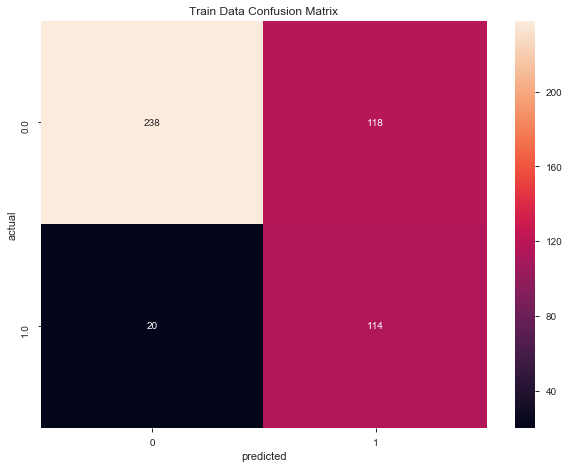

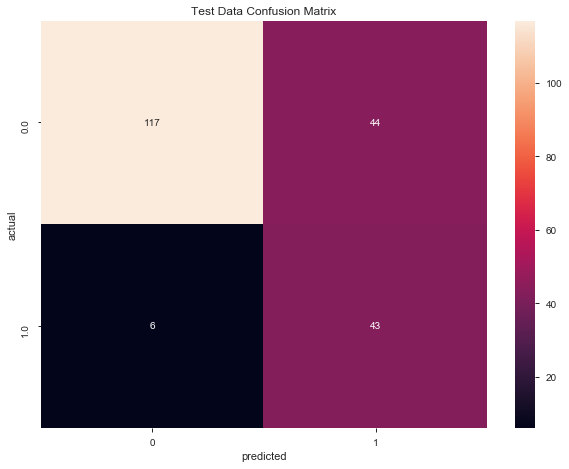

In [104]:
sns.heatmap(pd.crosstab(train_predict['actual'], train_predict['predicted']), annot=True, fmt='.0f')
plt.title('Train Data Confusion Matrix')
plt.show()
sns.heatmap(pd.crosstab(test_predict['actual'], test_predict['predicted']), annot=True, fmt='.0f')
plt.title('Test Data Confusion Matrix')
plt.show()



In [115]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_predict.actual, train_predict.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_predict.actual, test_predict.predicted))

The overall accuracy score for the Train Data is :  0.7183673469387755
The overall accuracy score for the Test Data  is :  0.7619047619047619


In [ ]:
metrics.classification_report?

In [ ]:
print(metrics.classification_report(train_predict.actual, train_predict.predicted))

In [ ]:
print(metrics.classification_report(test_predict.actual, test_predict.predicted))

### Decile Analysis

In [116]:
#Decile analysis
#Top-two deciles - High risk customers - will reject applications
#3rd,4th, 5th deciesl - medium risk customers - will accept application with proper scrutin
#6th decile onwards - low risk customers - accept the applications
?pd.qcut()

In [117]:
#Decile analysis for validation of models - Business validation

In [118]:
train_predict['Deciles']=pd.qcut(train_predict['prob'],10, labels=False)

# 0                    100
# min(prob)            max(prob)

In [119]:
train_predict.head()

,actual,prob,predicted,tp,fp,tn,fn,Deciles
357,1.0,0.585714,1,1.0,0.0,0.0,0.0,8
649,0.0,0.529760,1,0.0,1.0,0.0,0.0,8
291,0.0,0.060710,0,0.0,0.0,1.0,0.0,2
420,1.0,0.599708,1,1.0,0.0,0.0,0.0,8
177,0.0,0.130220,0,0.0,0.0,1.0,0.0,3


In [130]:
test_predict['Deciles']=pd.qcut(test_predict['prob'],10, labels=False)
test_predict.rename(columns={"actual":"actual_from_test","prob":"prob_test"})
test_predict.head()

,actual,prob,predicted,Deciles
158,1.0,0.213664,0,5
500,0.0,0.462456,1,7
396,0.0,0.059013,0,2
155,0.0,0.296537,1,6
321,1.0,0.300297,1,6


In [121]:

# Decile Analysis for train data

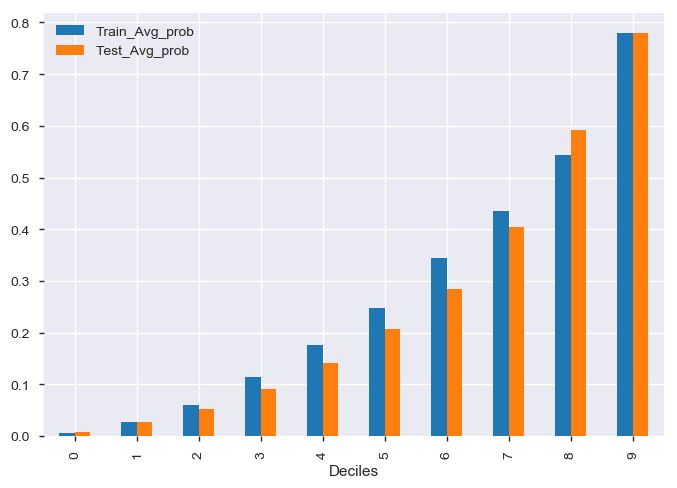

In [137]:
#----------------------
no_1s = train_predict[['Deciles','actual']].groupby(train_predict.Deciles).sum().sort_index(ascending=False)['actual']
no_total = train_predict[['Deciles','actual']].groupby(train_predict.Deciles).count().sort_index(ascending=False)['actual']

#----------------------
max_prob = train_predict[['Deciles','prob']].groupby(train_predict.Deciles).max().sort_index(ascending=False)['prob']
min_prob = train_predict[['Deciles','prob']].groupby(train_predict.Deciles).min().sort_index(ascending=False)['prob']

#----------------------
train_dec = train_predict.groupby("Deciles")[["prob"]].mean().add_prefix("Train_Avg_")
test_dec = test_predict.groupby("Deciles")[["prob"]].mean().add_prefix("Test_Avg_")

Final_Deciles = pd.concat([train_dec,test_dec],axis=1)
Final_Deciles.plot(kind = "bar")

In [126]:
Decile_analysis_train = pd.concat([max_prob], axis=1)

In [127]:
Decile_analysis_train

,prob
Deciles,
9,0.972238
8,0.674277
7,0.481492
6,0.312848
5,0.241148
4,0.166786
3,0.116723
2,0.065944
1,0.037317


In [129]:
# Decile Analysis for train data

no_1s = test_predict[['Deciles','actual']].groupby(test_predict.Deciles).sum().sort_index(ascending=False)['actual']
no_total = test_predict[['Deciles','actual']].groupby(test_predict.Deciles).count().sort_index(ascending=False)['actual']
max_prob = test_predict[['Deciles','prob']].groupby(test_predict.Deciles).max().sort_index(ascending=False)['prob']
min_prob = test_predict[['Deciles','prob']].groupby(test_predict.Deciles).min().sort_index(ascending=False)['prob']

Decile_analysis_test = pd.concat([min_prob], axis=1)

Decile_analysis_test

,prob
Deciles,
9,0.677471
8,0.491844
7,0.320830
6,0.255002
5,0.168111
4,0.117245
3,0.066429
2,0.040610
1,0.017489


In [ ]:
Decile_analysis_train.to_csv('Decile_analysis_train.csv')

In [ ]:
Decile_analysis_test.to_csv('Decile_analysis_test.csv')

## Predicting new customers (Implementation of Model on new data)

In [ ]:
# predciting new customers good or bad
bankloans_new.head()

In [ ]:
#before scoring new customers, you need to process the data using the sames steps you followed while building the model
#Excercise


In [ ]:
#Predicting values for bankloans_new data
bankloans_new['prob'] = result.predict(bankloans_new)

In [ ]:
bankloans_new.head()

In [ ]:
bankloans_new['default'] = bankloans_new['prob'].apply(lambda x: 1 if x > 0.23 else 0)

In [ ]:
bankloans_new.head()

In [ ]:
bankloans_new.default.value_counts()

In [ ]:
#We are rejecting applications for ~60 customers based on cut-off = 0.23

In [152]:
import numpy as np

In [164]:
s = pd.Series([1,2,4,5,6,8,13,16])

In [165]:
s.sample(n=1)

7    16
dtype: int64